In [1]:
from MultiTaskResNet import generateAgeGenderPredictionResNet

input_shape = (76, 94, 72)
model = generateAgeGenderPredictionResNet(input_shape, paddingType='same', initType='he_uniform', regAmount=0.00005, dropRate=0.2)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 T1_Img (InputLayer)            [(None, 76, 94, 72,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 94, 72,   224         ['T1_Img[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 76, 94, 72,   32         ['conv3d[0][0]']                 
 alization)                     8)                                                            

## Data input pipeline

In [2]:
import numpy as np
from scipy.ndimage import zoom
from tensorflow.keras.utils import Sequence
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint


def get_normalized(vol):
    norm_volume = (vol-vol.min())/(vol.max()-vol.min())
    return norm_volume


def downsample_volume(volume, target_shape=(70, 90, 70)):
    # Calculate the zoom factors for each dimension
    zoom_factors = np.array(target_shape) / np.array(volume.shape)
    
    # Perform the downsampling
    downsampled_volume = zoom(volume, zoom_factors, order=1)  # order=1 for linear interpolation
    
    return downsampled_volume


def get_cropped_volume(val_sample):
    axial_sum = np.max(val_sample, axis=2)
    axial_msk = axial_sum > axial_sum.mean()
    coronal_sum = np.max(val_sample, axis=1)
    coronal_msk = coronal_sum > coronal_sum.mean()
    
    object_indices = np.argwhere(axial_msk)
    min_bounds = object_indices.min(axis=0)
    max_bounds = object_indices.max(axis=0) + 1  # +1 to include the max index
    x_min, x_max, y_min, y_max = min_bounds[0], max_bounds[0], min_bounds[1], max_bounds[1]

    object_indices = np.argwhere(coronal_msk)
    min_bounds = object_indices.min(axis=0)
    max_bounds = object_indices.max(axis=0) + 1  # +1 to include the max index
    _, _, z_min, z_max = min_bounds[0], max_bounds[0], min_bounds[1], max_bounds[1]
    
    x_min, x_max = get_fix_cords(x_min, x_max, 152)
    y_min, y_max = get_fix_cords(y_min, y_max, 188)
    z_min, z_max = get_fix_cords(z_min, z_max, 144)
    cropped_volume = val_sample[x_min:x_max, y_min:y_max, z_min:z_max]
    cropped_volume = downsample_volume(cropped_volume, target_shape=(76, 94, 72))
    normalized_volume = get_normalized(cropped_volume)
    
    return normalized_volume
	
def get_fix_cords(xmn, xmx, fvalue):
    c_point = xmn + (xmx - xmn)/2
    nx_min = int(c_point-fvalue/2)
    nx_max = int(c_point+fvalue/2)
    return nx_min, nx_max

class DataGenerator(Sequence):
    def __init__(self, data_dir, participants, batch_size=8, dim=(76, 94, 72), shuffle=True):
        self.data_dir = data_dir
        self.participants = participants
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.participants))
        self.on_epoch_end()
        
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.participants) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        participants_temp = [self.participants.iloc[k] for k in indexes]
        X, y_age, y_gender = self.__data_generation(participants_temp)
        return X, {'AgePrediction': y_age, 'GenderPrediction': y_gender}
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, participants_temp):
        # Generates data containing batch_size samples
        X = np.empty((self.batch_size, *self.dim, 1))
        y_age = np.empty((self.batch_size), dtype=float)
        y_gender = np.empty((self.batch_size), dtype=float)
        
        for i, participant in enumerate(participants_temp):
            file_path = os.path.join(self.data_dir, f'sub-{participant["participant_id"]}_preproc-quasiraw_T1w.npy')
            volume = np.squeeze(np.load(file_path))
            x = get_cropped_volume(volume)
            X[i,] = x[..., np.newaxis]
            y_age[i] = participant["age"]
            y_gender[i] = 1 if participant["sex"] == 'male' else 0
        
        return X, y_age, y_gender

# Example usage
tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_labels\participants.tsv'
data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_quasiraw'

# Load participants information
participants = pd.read_csv(tsv_path, sep='\t')

# Split the participants into training and validation sets
train_participants, val_participants = train_test_split(participants, test_size=0.2, random_state=42)

# Create data generators for multitask learning
train_generator = DataGenerator(data_dir, train_participants, batch_size=8, dim=(76, 94, 72), shuffle=True)
val_generator = DataGenerator(data_dir, val_participants, batch_size=8, dim=(76, 94, 72), shuffle=False)

# Check the first batch to ensure the generator works correctly
X_batch, y_batch = train_generator.__getitem__(0)
print("Batch X shape:", X_batch.shape)
print("Batch y (age) shape:", y_batch['AgePrediction'].shape)
print("Batch y (gender) shape:", y_batch['GenderPrediction'].shape)
# print("Batch X sample:", X_batch[0])
print("Batch y (age) sample:", y_batch['AgePrediction'][0])
print("Batch y (gender) sample:", y_batch['GenderPrediction'][0])


Batch X shape: (8, 76, 94, 72, 1)
Batch y (age) shape: (8,)
Batch y (gender) shape: (8,)
Batch y (age) sample: 9.0
Batch y (gender) sample: 0.0


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os

# Define the DataGenerator and model functions as per the previous updates
# ...

# Paths
tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_labels\participants.tsv'
data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_quasiraw'

# Load participants information
participants = pd.read_csv(tsv_path, sep='\t')

# Split the participants into training and validation sets
train_participants, val_participants = train_test_split(participants, test_size=0.2, random_state=42)

# Create data generators
train_generator = DataGenerator(data_dir, train_participants, batch_size=16, dim=(76, 94, 72), shuffle=True)
val_generator = DataGenerator(data_dir, val_participants, batch_size=16, dim=(76, 94, 72), shuffle=False)

# Define the model
input_shape = (76, 94, 72)
model = generateAgeGenderPredictionResNet(input_shape, paddingType='same', initType='he_uniform', regAmount=0.00005, dropRate=0.2)

# Compile the model
model.compile(
    optimizer='adam', 
    loss={'AgePrediction': 'mean_squared_error', 'GenderPrediction': 'binary_crossentropy'},
    metrics={'AgePrediction': 'mae', 'GenderPrediction': 'accuracy'}
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('./test_weights/MTL_3D_ResNet_Best.h5', monitor='val_loss', save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./test_weights/logs_test')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, checkpoint, tensorboard]
)

# Save the trained model
model.save('./test_weights/MTL_3D_ResNet_weights.h5')

Epoch 1/100
  6/161 [>.............................] - ETA: 3:05 - loss: 1448.3722 - AgePrediction_loss: 1434.4977 - GenderPrediction_loss: 13.7733 - AgePrediction_mae: 28.6509 - GenderPrediction_accuracy: 0.5729

KeyboardInterrupt: 

In [28]:
# Create data generators
train_generator = DataGenerator(data_dir, train_participants, batch_size=16, dim=(70, 90, 70), shuffle=True)
val_generator = DataGenerator(data_dir, val_participants, batch_size=16, dim=(70, 90, 70), shuffle=False)

# Define the model
input_shape = (70, 90, 70)
model = generateAgePredictionResNet(input_shape, paddingType='same', initType='he_uniform', regAmount=0.00005, dropRate=0.2, includeScannerGender=False)
model_path = 'age_prediction_model_baan.h5' # Previously trained wegiths 
model = load_model(model_path)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./logs')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, checkpoint, tensorboard]
)

# Save the trained model
model.save('age_prediction_model_baan_n.h5')

Epoch 1/100
161/161 [==============================] - 314s 2s/step - batch: 80.0000 - size: 16.0000 - loss: 9358751.4113 - mean_absolute_error: 360.1777 - val_loss: 467130.7331 - val_mean_absolute_error: 116.9538
Epoch 2/100
161/161 [==============================] - 306s 2s/step - batch: 80.0000 - size: 16.0000 - loss: 1193370.0898 - mean_absolute_error: 137.2098 - val_loss: 84681.0109 - val_mean_absolute_error: 44.2465
Epoch 3/100
161/161 [==============================] - 302s 2s/step - batch: 80.0000 - size: 16.0000 - loss: 52331.9634 - mean_absolute_error: 33.5531 - val_loss: 7021.4397 - val_mean_absolute_error: 15.3906
Epoch 4/100
161/161 [==============================] - 302s 2s/step - batch: 80.0000 - size: 16.0000 - loss: 80696.9346 - mean_absolute_error: 39.0963 - val_loss: 5283.7132 - val_mean_absolute_error: 17.8752
Epoch 5/100
161/161 [==============================] - 300s 2s/step - batch: 80.0000 - size: 16.0000 - loss: 687801.0568 - mean_absolute_error: 63.1001 - val_

## Inference 

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# model_path = 'normalized_age_prediction_model.h5'
# model = load_model(model_path)
# model_path = 'multiTask_final_model.h5'
model_path = 'multiTask_best_weights.h5'
model = load_model(model_path)

tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_labels\participants.tsv'
participants = pd.read_csv(tsv_path, sep='\t')

# Load the numpy arrays and their corresponding ages
data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_quasiraw'
data = []
ages = []
pred_ages = []
i = 0
for participant_id, age in tqdm(zip(participants['participant_id'], participants['age'])):
    file_path = os.path.join(data_dir, f'sub-{participant_id}_preproc-quasiraw_T1w.npy')
    if os.path.exists(file_path):
        volume = np.squeeze(np.load(file_path))
        x = get_cropped_volume(volume)
        data = x[np.newaxis, ..., np.newaxis]
        pred_age = model.predict(data)
        print(pred_age[0])
        pred_ages.append(pred_age[0])
        ages.append(age)
        # i=i+1
        # if i==10:
        #     break


1it [00:04,  4.67s/it]

[[22.410727]]
[[34.616978]]
[[23.60645]]


6it [00:05,  2.20it/s]

[[21.76538]]
[[19.083347]]
[[23.264935]]


8it [00:05,  3.51it/s]

[[19.416311]]
[[16.582388]]


9it [00:05,  4.16it/s]

[[20.42078]]
[[16.996408]]
[[13.516345]]


13it [00:05,  6.71it/s]

[[21.192528]]
[[12.524864]]


14it [00:06,  7.22it/s]

[[19.655762]]
[[20.819134]]
[[20.79273]]


18it [00:06,  8.82it/s]

[[20.567654]]
[[24.439661]]
[[23.540462]]


20it [00:06,  6.49it/s]

[[38.06271]]


22it [00:07,  6.36it/s]

[[17.86404]]
[[19.326275]]


24it [00:07,  7.41it/s]

[[22.06169]]
[[20.960833]]


26it [00:07,  8.18it/s]

[[19.015873]]
[[26.56374]]


28it [00:07,  8.77it/s]

[[11.805909]]
[[44.435627]]


30it [00:08,  7.88it/s]

[[19.670033]]
[[18.531866]]


32it [00:08,  8.18it/s]

[[24.009792]]
[[21.557556]]


34it [00:08,  8.22it/s]

[[10.670193]]
[[12.196458]]


36it [00:08,  8.28it/s]

[[67.1754]]
[[21.809269]]


38it [00:09,  8.32it/s]

[[22.678055]]
[[23.610796]]


40it [00:09,  8.26it/s]

[[22.288494]]
[[25.882927]]


42it [00:09,  8.47it/s]

[[23.780193]]
[[15.1501465]]


44it [00:09,  8.20it/s]

[[23.76968]]
[[26.003876]]


46it [00:10,  7.90it/s]

[[21.66287]]
[[19.715675]]


48it [00:10,  7.64it/s]

[[19.895653]]
[[13.293475]]


49it [00:10,  7.53it/s]

[[21.405533]]


51it [00:10,  6.30it/s]

[[10.981372]]
[[9.844709]]


53it [00:11,  5.47it/s]

[[20.566183]]
[[18.444807]]


55it [00:11,  5.95it/s]

[[28.824745]]
[[21.232567]]


57it [00:11,  6.77it/s]

[[13.470359]]
[[12.58446]]


59it [00:12,  7.01it/s]

[[20.430424]]
[[20.723694]]


61it [00:12,  6.60it/s]

[[23.954264]]
[[18.921135]]


63it [00:12,  6.70it/s]

[[25.291576]]
[[25.382086]]


65it [00:13,  6.49it/s]

[[12.693756]]
[[17.574677]]


67it [00:13,  5.89it/s]

[[48.75239]]
[[29.982656]]


69it [00:13,  5.55it/s]

[[20.311249]]
[[35.98015]]


71it [00:14,  6.26it/s]

[[21.00161]]
[[21.619373]]


73it [00:14,  6.92it/s]

[[22.872225]]
[[10.471402]]


75it [00:14,  6.99it/s]

[[22.906662]]
[[27.76881]]


77it [00:14,  7.29it/s]

[[17.597849]]
[[9.749117]]


79it [00:15,  7.56it/s]

[[26.905579]]
[[18.69263]]


81it [00:15,  7.64it/s]

[[17.11105]]
[[12.771118]]


83it [00:15,  7.60it/s]

[[19.60868]]
[[23.725746]]


85it [00:15,  7.26it/s]

[[37.006428]]
[[15.207358]]


87it [00:16,  6.63it/s]

[[19.764687]]
[[22.909554]]


89it [00:16,  6.95it/s]

[[49.48789]]
[[38.60464]]


91it [00:16,  7.30it/s]

[[22.118155]]
[[20.006218]]


93it [00:17,  7.39it/s]

[[18.11333]]
[[22.309366]]


95it [00:17,  7.28it/s]

[[27.406895]]
[[25.557592]]


97it [00:17,  7.40it/s]

[[13.922317]]
[[27.496407]]


99it [00:17,  7.60it/s]

[[21.387089]]
[[22.133833]]


101it [00:18,  7.96it/s]

[[31.611687]]
[[20.563927]]


103it [00:18,  7.77it/s]

[[29.108158]]
[[12.073592]]


105it [00:18,  7.76it/s]

[[17.456272]]
[[21.85152]]


107it [00:18,  7.53it/s]

[[20.223011]]
[[21.176065]]


109it [00:19,  7.57it/s]

[[25.134722]]
[[18.033192]]


111it [00:19,  7.42it/s]

[[21.46585]]
[[20.716488]]


113it [00:19,  7.55it/s]

[[18.52687]]
[[34.958473]]


115it [00:19,  7.43it/s]

[[19.527872]]
[[20.006248]]


117it [00:20,  7.41it/s]

[[19.102043]]
[[24.0933]]


119it [00:20,  6.92it/s]

[[31.72261]]
[[21.100422]]


121it [00:20,  6.98it/s]

[[24.644857]]
[[12.639714]]


123it [00:21,  7.27it/s]

[[22.455168]]
[[21.009129]]


125it [00:21,  7.21it/s]

[[18.82702]]
[[16.308462]]


127it [00:21,  7.41it/s]

[[19.60925]]
[[17.925808]]


128it [00:21,  7.45it/s]

[[39.737827]]


130it [00:22,  6.13it/s]

[[21.966248]]
[[25.725086]]


132it [00:22,  6.71it/s]

[[19.086449]]
[[13.440705]]


134it [00:22,  6.92it/s]

[[20.105091]]
[[22.030872]]


136it [00:23,  7.16it/s]

[[12.254497]]
[[19.914337]]


138it [00:23,  7.42it/s]

[[18.735203]]
[[32.632717]]


140it [00:23,  7.32it/s]

[[11.891477]]
[[49.30647]]


142it [00:23,  7.30it/s]

[[11.81051]]
[[19.500486]]


144it [00:24,  7.49it/s]

[[16.483616]]
[[20.689127]]


146it [00:24,  7.62it/s]

[[51.923153]]
[[20.782612]]


148it [00:24,  7.90it/s]

[[18.9416]]
[[8.95583]]


150it [00:24,  7.56it/s]

[[22.335814]]
[[23.88398]]


152it [00:25,  7.59it/s]

[[20.644562]]
[[10.630387]]


154it [00:25,  7.38it/s]

[[11.916075]]
[[10.841748]]


156it [00:25,  7.24it/s]

[[20.67065]]
[[22.12021]]


158it [00:25,  7.48it/s]

[[12.39886]]
[[8.415856]]


160it [00:26,  7.31it/s]

[[25.944248]]
[[23.417236]]


162it [00:26,  7.18it/s]

[[36.599804]]
[[57.134205]]


164it [00:26,  7.35it/s]

[[21.596924]]
[[56.13221]]


166it [00:27,  7.40it/s]

[[21.436893]]
[[22.769997]]


168it [00:27,  7.35it/s]

[[18.986847]]
[[25.815746]]


170it [00:27,  7.37it/s]

[[24.81845]]
[[18.851532]]


172it [00:27,  7.45it/s]

[[24.10213]]
[[18.627935]]


174it [00:28,  7.50it/s]

[[17.839321]]
[[21.222904]]


176it [00:28,  7.36it/s]

[[47.623695]]
[[41.427166]]


178it [00:28,  7.32it/s]

[[10.308911]]
[[23.89241]]


180it [00:28,  7.25it/s]

[[12.22557]]
[[22.250704]]


182it [00:29,  7.35it/s]

[[20.181007]]
[[19.645607]]


184it [00:29,  7.36it/s]

[[17.08182]]
[[17.31249]]


186it [00:29,  7.52it/s]

[[23.469141]]
[[13.937631]]


188it [00:30,  7.61it/s]

[[17.170826]]
[[22.972298]]


190it [00:30,  7.43it/s]

[[22.501818]]
[[17.243013]]


192it [00:30,  7.55it/s]

[[10.547925]]
[[12.017377]]


194it [00:30,  7.21it/s]

[[22.754116]]
[[19.879143]]


196it [00:31,  7.36it/s]

[[21.621925]]
[[20.94905]]


198it [00:31,  7.25it/s]

[[16.986221]]
[[17.022457]]


200it [00:31,  7.20it/s]

[[10.974498]]
[[21.716152]]


202it [00:31,  7.44it/s]

[[18.799572]]
[[14.203203]]


204it [00:32,  7.55it/s]

[[14.191134]]
[[16.909088]]


206it [00:32,  7.43it/s]

[[26.13347]]
[[19.5036]]


208it [00:32,  7.64it/s]

[[37.58358]]
[[20.229393]]


210it [00:32,  7.32it/s]

[[31.460262]]
[[23.094189]]


212it [00:33,  7.39it/s]

[[20.19983]]
[[23.861027]]


214it [00:33,  6.87it/s]

[[21.938324]]
[[21.674206]]


216it [00:33,  7.12it/s]

[[18.376865]]
[[49.945988]]


218it [00:34,  7.38it/s]

[[24.968245]]
[[12.140794]]


220it [00:34,  7.32it/s]

[[26.51998]]
[[13.184058]]


222it [00:34,  7.40it/s]

[[43.90835]]
[[23.93385]]


224it [00:34,  7.32it/s]

[[19.861816]]
[[13.708903]]


226it [00:35,  7.57it/s]

[[10.288947]]
[[22.54153]]


228it [00:35,  7.49it/s]

[[31.387007]]
[[21.422943]]


230it [00:35,  7.42it/s]

[[20.044695]]
[[21.201845]]


232it [00:36,  7.29it/s]

[[20.168497]]
[[20.87747]]


234it [00:36,  7.27it/s]

[[14.892482]]
[[20.796036]]


236it [00:36,  7.44it/s]

[[21.976524]]
[[32.809734]]


238it [00:36,  7.60it/s]

[[21.470407]]
[[14.5435915]]


240it [00:37,  7.05it/s]

[[20.446804]]
[[26.869133]]


242it [00:37,  7.21it/s]

[[21.521942]]
[[42.5033]]


244it [00:37,  6.70it/s]

[[12.481829]]
[[22.048882]]


246it [00:37,  7.18it/s]

[[27.798752]]
[[12.862799]]


248it [00:38,  7.48it/s]

[[20.212234]]
[[23.780193]]


249it [00:38,  7.36it/s]

[[22.752186]]


250it [00:38,  6.00it/s]

[[16.503542]]
[[24.551336]]


253it [00:39,  5.73it/s]

[[40.438282]]
[[20.443558]]


254it [00:39,  5.29it/s]

[[23.248617]]


256it [00:39,  4.71it/s]

[[13.475338]]
[[76.18979]]


258it [00:40,  5.64it/s]

[[22.80487]]
[[17.997349]]


260it [00:40,  6.53it/s]

[[20.359388]]
[[12.636811]]


262it [00:40,  6.77it/s]

[[70.0273]]
[[24.48477]]


264it [00:40,  6.83it/s]

[[17.369333]]
[[20.842745]]


266it [00:41,  7.14it/s]

[[23.127409]]
[[12.34434]]


267it [00:41,  7.25it/s]

[[10.8236885]]


268it [00:41,  6.16it/s]

[[21.415764]]
[[20.20236]]


271it [00:42,  6.32it/s]

[[18.202654]]
[[20.429064]]


273it [00:42,  6.94it/s]

[[17.366285]]
[[21.723866]]


275it [00:42,  7.08it/s]

[[19.907228]]
[[18.985975]]


277it [00:42,  7.22it/s]

[[37.778137]]
[[19.496233]]


279it [00:43,  7.33it/s]

[[33.949745]]
[[18.7384]]


281it [00:43,  6.55it/s]

[[15.884238]]
[[39.270947]]


283it [00:43,  6.84it/s]

[[12.04537]]
[[18.193619]]


285it [00:44,  7.26it/s]

[[26.440556]]
[[13.219335]]


287it [00:44,  7.50it/s]

[[14.076575]]
[[18.583645]]


289it [00:44,  7.49it/s]

[[59.50155]]
[[12.420532]]


291it [00:44,  7.46it/s]

[[19.367859]]
[[24.720858]]


293it [00:45,  7.26it/s]

[[20.75425]]
[[22.893515]]


295it [00:45,  7.39it/s]

[[10.800165]]
[[13.538997]]


297it [00:45,  7.47it/s]

[[14.037705]]
[[12.366183]]


299it [00:45,  7.45it/s]

[[22.967663]]
[[23.129711]]


301it [00:46,  7.37it/s]

[[14.596548]]
[[19.203268]]


303it [00:46,  7.09it/s]

[[21.751371]]
[[24.142706]]


305it [00:46,  7.22it/s]

[[28.889788]]
[[43.86237]]


307it [00:47,  7.30it/s]

[[11.939704]]
[[51.874622]]


309it [00:47,  7.25it/s]

[[18.653627]]
[[21.335926]]


311it [00:47,  7.09it/s]

[[20.748192]]
[[17.734215]]


313it [00:47,  7.33it/s]

[[19.539883]]
[[19.986404]]


315it [00:48,  7.44it/s]

[[15.240224]]
[[19.20713]]


317it [00:48,  7.04it/s]

[[25.203762]]
[[17.28341]]


319it [00:48,  7.46it/s]

[[14.207024]]
[[39.650257]]


321it [00:48,  7.59it/s]

[[24.042992]]
[[21.23246]]


323it [00:49,  7.72it/s]

[[60.95548]]
[[22.680904]]


325it [00:49,  7.51it/s]

[[16.42021]]
[[19.002018]]


327it [00:49,  7.56it/s]

[[20.025948]]
[[22.021393]]


329it [00:50,  7.13it/s]

[[10.848005]]
[[12.257388]]


331it [00:50,  6.94it/s]

[[18.02438]]
[[19.037193]]


333it [00:50,  7.14it/s]

[[21.400469]]
[[11.682105]]


335it [00:50,  7.65it/s]

[[21.86439]]
[[23.281841]]


337it [00:51,  6.70it/s]

[[21.493706]]
[[16.85973]]


339it [00:51,  7.26it/s]

[[11.21975]]
[[18.51161]]


341it [00:51,  7.21it/s]

[[45.87322]]
[[12.84862]]


343it [00:52,  7.51it/s]

[[25.18531]]
[[22.14769]]


345it [00:52,  7.38it/s]

[[27.477406]]
[[64.85351]]


347it [00:52,  7.56it/s]

[[15.803224]]
[[24.823887]]


349it [00:52,  7.49it/s]

[[21.018782]]
[[11.4172125]]


350it [00:52,  7.27it/s]

[[15.931064]]


352it [00:53,  6.61it/s]

[[13.775117]]
[[31.545351]]


354it [00:53,  7.00it/s]

[[26.322872]]
[[19.498648]]


356it [00:53,  7.31it/s]

[[15.387281]]
[[13.191625]]


358it [00:54,  7.44it/s]

[[20.167408]]
[[62.642677]]


360it [00:54,  7.60it/s]

[[19.672436]]
[[18.877628]]


362it [00:54,  7.52it/s]

[[22.823158]]
[[17.689917]]


364it [00:54,  7.46it/s]

[[19.291485]]
[[14.445321]]


366it [00:55,  7.65it/s]

[[57.584415]]
[[16.757229]]


368it [00:55,  7.51it/s]

[[11.666402]]
[[27.383104]]


370it [00:55,  6.70it/s]

[[23.991756]]
[[15.180791]]


372it [00:55,  7.15it/s]

[[38.090923]]
[[18.435041]]


374it [00:56,  7.55it/s]

[[29.357485]]
[[11.466945]]


376it [00:56,  7.59it/s]

[[22.301601]]
[[23.943188]]


378it [00:56,  7.37it/s]

[[22.320583]]
[[25.078396]]


380it [00:57,  7.52it/s]

[[11.413341]]
[[17.729706]]


382it [00:57,  7.37it/s]

[[14.532447]]
[[38.464848]]


384it [00:57,  7.70it/s]

[[11.82558]]
[[22.502626]]


386it [00:57,  7.46it/s]

[[26.98136]]
[[19.686085]]


388it [00:58,  7.57it/s]

[[19.91528]]
[[20.331116]]


390it [00:58,  7.36it/s]

[[10.817328]]
[[21.683302]]


392it [00:58,  7.41it/s]

[[14.442126]]
[[19.954868]]


394it [00:58,  7.42it/s]

[[23.109215]]
[[10.961978]]


396it [00:59,  7.58it/s]

[[44.70601]]
[[11.92725]]


398it [00:59,  7.36it/s]

[[19.232403]]
[[16.948479]]


400it [00:59,  7.26it/s]

[[19.389486]]
[[21.629227]]


402it [01:00,  6.69it/s]

[[19.439844]]
[[14.795859]]


404it [01:00,  6.98it/s]

[[13.37886]]
[[25.009407]]


406it [01:00,  7.23it/s]

[[20.197563]]
[[18.592873]]


408it [01:00,  7.35it/s]

[[22.007988]]
[[15.870763]]


409it [01:01,  7.00it/s]

[[28.41325]]
[[44.454594]]


412it [01:01,  6.53it/s]

[[22.771942]]
[[17.306173]]


414it [01:01,  6.79it/s]

[[22.756208]]
[[18.41117]]


416it [01:02,  6.92it/s]

[[15.817361]]
[[8.632679]]


418it [01:02,  7.16it/s]

[[22.403542]]
[[40.221638]]


420it [01:02,  7.57it/s]

[[21.012623]]
[[63.43359]]


422it [01:02,  8.01it/s]

[[9.59559]]
[[26.793]]


424it [01:03,  7.94it/s]

[[17.001987]]
[[22.157036]]


426it [01:03,  7.68it/s]

[[19.6789]]
[[21.573479]]


428it [01:03,  6.58it/s]

[[17.309164]]
[[16.162817]]


430it [01:04,  6.92it/s]

[[31.564743]]
[[19.023273]]


432it [01:04,  7.22it/s]

[[13.485541]]
[[25.905327]]


434it [01:04,  7.06it/s]

[[24.745281]]
[[11.96117]]


436it [01:04,  7.19it/s]

[[20.676914]]
[[12.342503]]


437it [01:05,  6.91it/s]

[[13.747252]]


438it [01:05,  5.89it/s]

[[20.661737]]
[[19.502625]]


441it [01:05,  5.81it/s]

[[20.987633]]
[[21.609844]]


443it [01:06,  6.18it/s]

[[13.4201975]]
[[22.550653]]


445it [01:06,  6.56it/s]

[[20.034393]]
[[20.140385]]


447it [01:06,  6.70it/s]

[[56.472424]]
[[19.61036]]


449it [01:06,  7.18it/s]

[[20.591362]]
[[54.856937]]


451it [01:07,  7.54it/s]

[[23.423994]]
[[18.68121]]


453it [01:07,  7.74it/s]

[[19.154957]]
[[18.801174]]


455it [01:07,  7.65it/s]

[[18.661896]]
[[20.921074]]


456it [01:07,  7.81it/s]

[[18.41706]]


458it [01:08,  6.94it/s]

[[19.494759]]
[[21.75217]]


460it [01:08,  7.28it/s]

[[42.836475]]
[[10.92459]]


462it [01:08,  7.57it/s]

[[12.577806]]
[[27.769674]]


464it [01:08,  7.48it/s]

[[20.88946]]
[[16.8436]]


466it [01:09,  7.23it/s]

[[24.719013]]
[[18.178566]]


468it [01:09,  7.20it/s]

[[12.034638]]
[[16.11441]]


470it [01:09,  7.37it/s]

[[21.993925]]
[[35.207012]]


472it [01:10,  7.26it/s]

[[21.96772]]
[[25.176289]]


474it [01:10,  7.50it/s]

[[10.724837]]
[[43.69532]]


476it [01:10,  7.75it/s]

[[20.773207]]
[[10.597362]]


478it [01:10,  7.68it/s]

[[60.573566]]
[[14.272674]]


480it [01:11,  7.96it/s]

[[34.379627]]
[[18.870962]]


482it [01:11,  7.81it/s]

[[17.674484]]
[[18.093891]]


484it [01:11,  7.60it/s]

[[24.020283]]
[[21.159307]]


486it [01:11,  7.52it/s]

[[42.643078]]
[[24.501495]]


488it [01:12,  7.70it/s]

[[64.14007]]
[[21.665026]]


490it [01:12,  7.57it/s]

[[12.058721]]
[[23.793331]]


492it [01:12,  7.01it/s]

[[49.397327]]
[[22.602463]]


494it [01:12,  7.52it/s]

[[22.545282]]
[[18.671703]]


496it [01:13,  7.76it/s]

[[22.583485]]
[[22.053898]]


498it [01:13,  7.26it/s]

[[15.299582]]
[[13.839329]]


500it [01:13,  7.27it/s]

[[35.382526]]
[[16.757765]]


502it [01:13,  7.46it/s]

[[21.863262]]
[[19.58646]]


504it [01:14,  7.03it/s]

[[20.384514]]
[[18.863602]]


506it [01:14,  7.32it/s]

[[25.964653]]
[[28.724989]]


508it [01:14,  7.53it/s]

[[21.731503]]
[[41.8979]]


510it [01:15,  7.73it/s]

[[17.771088]]
[[18.89033]]


512it [01:15,  7.71it/s]

[[16.08618]]
[[12.256144]]


514it [01:15,  7.46it/s]

[[15.460153]]
[[46.561504]]


516it [01:15,  7.29it/s]

[[11.147497]]
[[25.580498]]


518it [01:16,  7.03it/s]

[[24.90944]]
[[11.962273]]


520it [01:16,  6.98it/s]

[[11.473517]]
[[18.877068]]


522it [01:16,  7.20it/s]

[[21.754417]]
[[9.455014]]


524it [01:17,  6.75it/s]

[[12.016425]]
[[23.997635]]


526it [01:17,  6.86it/s]

[[16.889942]]
[[64.96697]]


528it [01:17,  6.83it/s]

[[18.686094]]
[[22.950687]]


530it [01:17,  7.03it/s]

[[19.561289]]
[[19.833918]]


532it [01:18,  7.09it/s]

[[20.410694]]
[[24.037178]]


534it [01:18,  6.99it/s]

[[22.63514]]
[[12.216828]]


536it [01:18,  7.23it/s]

[[13.647025]]
[[62.35308]]


538it [01:18,  7.50it/s]

[[22.560568]]
[[21.046144]]


540it [01:19,  7.14it/s]

[[20.901918]]
[[15.787208]]


542it [01:19,  7.27it/s]

[[32.097946]]
[[17.596138]]


544it [01:19,  7.22it/s]

[[9.822198]]
[[18.164484]]


546it [01:20,  6.95it/s]

[[12.940985]]
[[45.415985]]


548it [01:20,  6.80it/s]

[[35.209217]]
[[48.26812]]


550it [01:20,  7.05it/s]

[[21.260834]]
[[22.879642]]


552it [01:20,  7.11it/s]

[[25.15282]]
[[20.029114]]


554it [01:21,  7.02it/s]

[[21.145983]]
[[12.181992]]


556it [01:21,  6.97it/s]

[[20.844847]]
[[11.502984]]


558it [01:21,  6.68it/s]

[[25.967253]]
[[12.224712]]


560it [01:22,  6.78it/s]

[[19.547102]]
[[14.586108]]


562it [01:22,  6.56it/s]

[[22.392956]]
[[13.831871]]


564it [01:22,  6.71it/s]

[[19.059273]]
[[70.16315]]


566it [01:23,  6.97it/s]

[[25.528322]]
[[21.278584]]


568it [01:23,  6.62it/s]

[[13.555596]]
[[13.235065]]


569it [01:23,  6.77it/s]

[[10.131141]]


571it [01:23,  6.03it/s]

[[19.338394]]
[[20.00549]]


573it [01:24,  6.53it/s]

[[20.059845]]
[[27.858406]]


574it [01:24,  6.73it/s]

[[18.515862]]


576it [01:24,  6.34it/s]

[[19.844395]]
[[25.81866]]


578it [01:25,  5.93it/s]

[[11.632626]]
[[30.066082]]


580it [01:25,  6.08it/s]

[[21.399776]]
[[13.187765]]


582it [01:25,  6.82it/s]

[[19.848026]]
[[28.335934]]


584it [01:25,  6.05it/s]

[[37.94883]]
[[22.65308]]


586it [01:26,  5.99it/s]

[[20.721462]]
[[20.972778]]


588it [01:26,  6.73it/s]

[[11.260461]]
[[20.016804]]


590it [01:26,  6.97it/s]

[[63.462505]]
[[45.921047]]


592it [01:27,  7.17it/s]

[[22.238432]]
[[31.36277]]


594it [01:27,  6.87it/s]

[[15.901311]]
[[14.966886]]


596it [01:27,  7.02it/s]

[[16.677105]]
[[25.669872]]


598it [01:28,  7.26it/s]

[[10.888952]]
[[12.43987]]


600it [01:28,  7.19it/s]

[[37.608604]]
[[17.971375]]


602it [01:28,  7.18it/s]

[[19.791973]]
[[64.75412]]


604it [01:28,  7.20it/s]

[[19.87249]]
[[23.655037]]


606it [01:29,  7.21it/s]

[[19.288815]]
[[11.517716]]


608it [01:29,  7.13it/s]

[[30.859512]]
[[21.634274]]


610it [01:29,  7.08it/s]

[[20.380613]]
[[17.690498]]


611it [01:29,  7.18it/s]

[[22.86794]]


612it [01:30,  5.70it/s]

[[14.926512]]


614it [01:30,  5.34it/s]

[[28.979153]]
[[18.994698]]


616it [01:30,  6.14it/s]

[[20.596426]]
[[20.267708]]


618it [01:31,  6.67it/s]

[[20.2342]]
[[19.009163]]


620it [01:31,  6.93it/s]

[[12.152532]]
[[20.689487]]


622it [01:31,  6.57it/s]

[[28.295269]]
[[23.348406]]


623it [01:31,  6.23it/s]

[[20.235909]]


625it [01:32,  5.86it/s]

[[23.874853]]
[[27.670502]]


627it [01:32,  5.85it/s]

[[11.761043]]
[[15.086903]]


629it [01:32,  6.10it/s]

[[9.877212]]
[[21.05419]]


631it [01:33,  6.63it/s]

[[32.773533]]
[[10.475682]]


633it [01:33,  6.81it/s]

[[21.768686]]
[[19.277895]]


635it [01:33,  6.78it/s]

[[23.69188]]
[[30.57547]]


637it [01:34,  6.92it/s]

[[25.319921]]
[[29.433723]]


639it [01:34,  6.88it/s]

[[23.035192]]
[[11.009328]]


641it [01:34,  7.01it/s]

[[10.48812]]
[[19.519487]]


643it [01:34,  7.26it/s]

[[26.736921]]
[[19.303791]]


645it [01:35,  6.76it/s]

[[19.20425]]
[[28.853943]]


647it [01:35,  6.99it/s]

[[28.446472]]
[[59.114346]]


649it [01:35,  7.09it/s]

[[25.547129]]
[[20.541927]]


651it [01:36,  7.03it/s]

[[17.522106]]
[[30.966051]]


653it [01:36,  7.17it/s]

[[19.5262]]
[[23.338785]]


655it [01:36,  7.36it/s]

[[18.934444]]
[[22.142208]]


657it [01:36,  7.48it/s]

[[21.752943]]
[[32.08145]]


659it [01:37,  7.30it/s]

[[38.162075]]
[[19.993494]]


661it [01:37,  7.07it/s]

[[25.660183]]
[[18.005909]]


663it [01:37,  7.22it/s]

[[42.829235]]
[[20.131184]]


665it [01:37,  7.34it/s]

[[29.91787]]
[[18.808487]]


667it [01:38,  7.43it/s]

[[27.568478]]
[[22.68337]]


668it [01:38,  7.18it/s]

[[23.076805]]


670it [01:38,  5.15it/s]

[[20.45444]]
[[25.53896]]


672it [01:39,  6.02it/s]

[[13.175199]]
[[12.868659]]


674it [01:39,  6.67it/s]

[[17.938148]]
[[23.049156]]


676it [01:39,  6.81it/s]

[[47.85295]]
[[46.272762]]


678it [01:40,  6.74it/s]

[[19.665928]]
[[18.839653]]


679it [01:40,  7.00it/s]

[[18.706158]]


680it [01:40,  5.46it/s]

[[16.099434]]


681it [01:40,  4.35it/s]

[[24.234158]]


683it [01:41,  4.04it/s]

[[37.3866]]
[[18.135502]]


684it [01:41,  3.36it/s]

[[26.494326]]


685it [01:42,  3.50it/s]

[[27.305553]]


686it [01:42,  3.36it/s]

[[22.026587]]


687it [01:43,  2.42it/s]

[[15.453437]]


689it [01:43,  3.23it/s]

[[22.583115]]
[[12.431851]]


691it [01:43,  4.29it/s]

[[38.998787]]
[[18.217823]]


692it [01:43,  4.97it/s]

[[44.282383]]


694it [01:44,  4.89it/s]

[[17.628952]]
[[13.567548]]


695it [01:44,  4.71it/s]

[[57.700977]]


697it [01:44,  5.26it/s]

[[15.181308]]
[[51.418964]]


698it [01:45,  4.58it/s]

[[20.19331]]


699it [01:45,  3.07it/s]

[[22.094566]]


701it [01:46,  3.37it/s]

[[21.291504]]
[[18.689342]]


703it [01:46,  4.38it/s]

[[22.67439]]
[[19.911541]]


705it [01:47,  4.37it/s]

[[27.401653]]
[[18.629002]]


706it [01:47,  3.56it/s]

[[22.341934]]


707it [01:47,  3.42it/s]

[[38.408638]]


708it [01:48,  3.47it/s]

[[18.32091]]


709it [01:48,  3.52it/s]

[[11.983029]]
[[20.159279]]


712it [01:49,  4.24it/s]

[[10.87802]]
[[24.55505]]


713it [01:49,  4.54it/s]

[[10.214864]]


714it [01:49,  3.58it/s]

[[20.490017]]
[[18.019194]]


717it [01:50,  3.94it/s]

[[21.280537]]
[[19.3646]]


718it [01:50,  4.45it/s]

[[40.5639]]


720it [01:51,  5.00it/s]

[[24.592289]]
[[20.71438]]


721it [01:51,  3.98it/s]

[[12.472173]]


723it [01:51,  4.75it/s]

[[23.703995]]
[[20.01756]]


725it [01:52,  5.89it/s]

[[16.49154]]
[[18.903639]]


727it [01:52,  6.58it/s]

[[23.091421]]
[[12.803385]]


729it [01:52,  7.10it/s]

[[20.797802]]
[[12.332477]]


731it [01:52,  6.80it/s]

[[20.573605]]
[[18.851868]]


732it [01:53,  6.80it/s]

[[18.925814]]


733it [01:53,  5.22it/s]

[[13.912339]]
[[13.538354]]


736it [01:53,  5.16it/s]

[[19.637205]]
[[30.648048]]


738it [01:54,  5.42it/s]

[[19.854467]]
[[23.374065]]


740it [01:54,  6.14it/s]

[[18.72166]]
[[40.1089]]


742it [01:54,  6.45it/s]

[[18.287907]]
[[29.47962]]


744it [01:55,  6.99it/s]

[[24.09474]]
[[52.34831]]


746it [01:55,  7.03it/s]

[[19.324461]]
[[28.203047]]


748it [01:55,  7.43it/s]

[[23.789673]]
[[10.488498]]


750it [01:55,  7.15it/s]

[[20.138538]]
[[12.880909]]


752it [01:56,  7.25it/s]

[[14.500089]]
[[21.57483]]


754it [01:56,  7.19it/s]

[[36.760086]]
[[20.825985]]


756it [01:56,  7.45it/s]

[[19.839163]]
[[39.02193]]


757it [01:56,  6.48it/s]

[[13.897021]]


In [11]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model


model_path = 'multiTask_best_weights.h5'
model = load_model(model_path)

tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_labels\participants.tsv'
participants = pd.read_csv(tsv_path, sep='\t')

# Load the numpy arrays and their corresponding ages and genders
data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_quasiraw'
ages = []
genders = []
pred_ages = []
pred_genders = []

for participant_id, age, sex in tqdm(zip(participants['participant_id'], participants['age'], participants['sex'])):
    file_path = os.path.join(data_dir, f'sub-{participant_id}_preproc-quasiraw_T1w.npy')
    if os.path.exists(file_path):
        volume = np.squeeze(np.load(file_path))
        x = get_cropped_volume(volume)
        data = x[np.newaxis, ..., np.newaxis]
        pred_age, pred_gender = model.predict(data)
        pred_ages.append(pred_age[0])
        pred_genders.append(pred_gender[0])
        ages.append(age)
        genders.append(1 if sex == 'male' else 0)

ages = np.array(ages)
pred_ages = np.array(pred_ages)
genders = np.array(genders)
pred_genders = np.array(pred_genders)

# Evaluate the model's performance
mae_age = mean_absolute_error(ages, pred_ages)
mse_age = mean_squared_error(ages, pred_ages)
corr_age, _ = pearsonr(ages, pred_ages)

accuracy_gender = np.mean((pred_genders > 0.5) == genders)

print(f'Age MAE: {mae_age}')
print(f'Age MSE: {mse_age}')
# print(f'Age Correlation: {corr_age}')
print(f'Gender Accuracy: {accuracy_gender}')

Age MAE: 3.4927321774294326
Age MSE: 29.15878715377121
Gender Accuracy: 0.5080647553699597


In [15]:
# Evaluate the model's performance
def evaluate_age_performance(true_ages, predicted_ages):
    mae = mean_absolute_error(true_ages, predicted_ages)
    mse = mean_squared_error(true_ages, predicted_ages)
    # corr, _ = pearsonr(true_ages, predicted_ages)
    return mae, mse

# Overall performance
mae_age, mse_age = evaluate_age_performance(ages, pred_ages)
accuracy_gender = np.mean((pred_genders > 0.5) == genders)

# Performance for males
male_mask = genders == 1
mae_age_male, mse_age_male = evaluate_age_performance(ages[male_mask], pred_ages[male_mask])

# Performance for females
female_mask = genders == 0
mae_age_female, mse_age_female = evaluate_age_performance(ages[female_mask], pred_ages[female_mask])

print(f'Overall Age MAE: {mae_age}')
print(f'Overall Age MSE: {mse_age}')
# print(f'Overall Age Correlation: {corr_age}')
print(f'Overall Gender Accuracy: {accuracy_gender}')

print(f'Male Age MAE: {mae_age_male}')
print(f'Male Age MSE: {mse_age_male}')
# print(f'Male Age Correlation: {corr_age_male}')

print(f'Female Age MAE: {mae_age_female}')
print(f'Female Age MSE: {mse_age_female}')
# print(f'Female Age Correlation: {corr_age_female}')

Overall Age MAE: 3.4927321774294326
Overall Age MSE: 29.15878715377121
Overall Gender Accuracy: 0.5080647553699597
Male Age MAE: 3.203827810048379
Male Age MSE: 21.90623073892201
Female Age MAE: 3.8489623413388143
Female Age MSE: 38.101467334912705


In [20]:
pred_ages = np.squeeze(pred_ages)
male_mask.shape, ages.shape, pred_ages.shape

((757,), (757,), (757,))

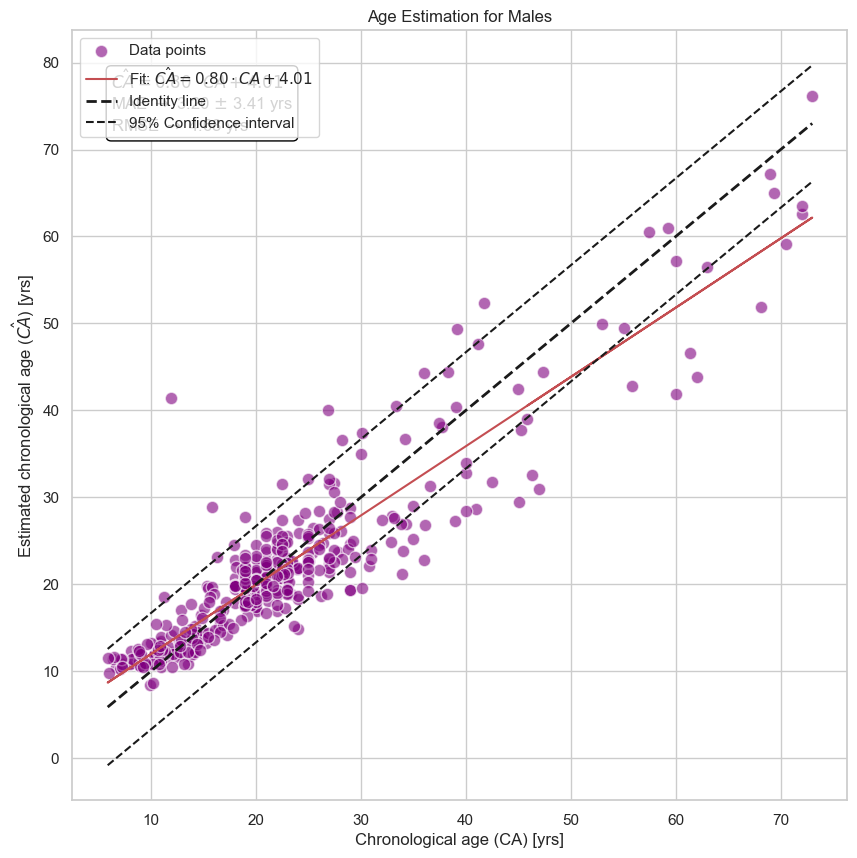

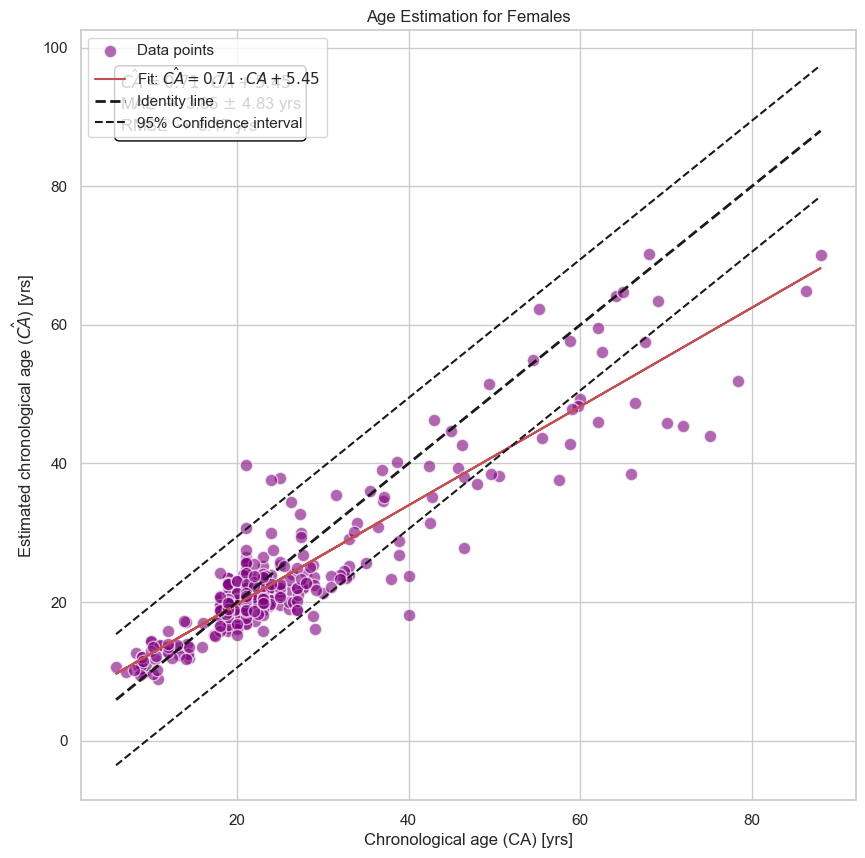

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

def plot_results(ages, pred_ages, mae, sd, bias, rmse, title):
    # Plotting
    plt.figure(figsize=(10, 10))
    sns.set(style="whitegrid")
    
    # Scatter plot of actual vs predicted ages
    plt.scatter(ages, pred_ages, color='purple', alpha=0.6, edgecolor='w', s=80, label='Data points')
    
    # Regression line
    slope, intercept, r_value, p_value, std_err = linregress(ages, pred_ages)
    plt.plot(ages, intercept + slope * ages, 'r', label=f'Fit: $\\hat{{CA}} = {slope:.2f} \cdot CA + {intercept:.2f}$')

    # Identity line (y = x)
    plt.plot([ages.min(), ages.max()], [ages.min(), ages.max()], 'k--', lw=2, label='Identity line')

    # Confidence intervals
    plt.plot([ages.min(), ages.max()], [ages.min() + 1.96 * sd, ages.max() + 1.96 * sd], 'k--')
    plt.plot([ages.min(), ages.max()], [ages.min() - 1.96 * sd, ages.max() - 1.96 * sd], 'k--', label='95% Confidence interval')
    
    # Annotations
    plt.xlabel('Chronological age (CA) [yrs]')
    plt.ylabel('Estimated chronological age ($\\hat{CA}$) [yrs]')
    plt.title(title)
    plt.legend()
    
    # Annotation with metrics
    metrics_text = (f'$\\hat{{CA}} = {slope:.2f} \cdot CA + {intercept:.2f}$\n'
                    f'MAE $\\rightarrow$ {mae:.2f} $\\pm$ {sd:.2f} yrs\n'
                    f'RMSE $\\rightarrow$ {rmse:.2f} yrs')
    plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
                 horizontalalignment='left', verticalalignment='top')

    plt.show()

# Calculate additional metrics
def calculate_metrics(true_ages, predicted_ages):
    mae = mean_absolute_error(true_ages, predicted_ages)
    rmse = np.sqrt(mean_squared_error(true_ages, predicted_ages))
    sd = np.std(np.abs(true_ages - predicted_ages))
    bias = np.mean(true_ages - predicted_ages)
    return mae, sd, bias, rmse

# Metrics for males
mae_age_male, sd_age_male, bias_age_male, rmse_age_male = calculate_metrics(ages[male_mask], pred_ages[male_mask])
plot_results(ages[male_mask], pred_ages[male_mask], mae_age_male, sd_age_male, bias_age_male, rmse_age_male, title='Age Estimation for Males')

# Metrics for females
mae_age_female, sd_age_female, bias_age_female, rmse_age_female = calculate_metrics(ages[female_mask], pred_ages[female_mask])
plot_results(ages[female_mask], pred_ages[female_mask], mae_age_female, sd_age_female, bias_age_female, rmse_age_female, title='Age Estimation for Females')
